A notebook to train and test an ImageNet-pretrained VGG-16 neural network. 

This notebook assumes that the chips for each class are stored in a separate subdirectory named after the corresponding class.

tif, png, and jpg formats are supported. 

In [46]:
import os
import cv2
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from os.path import join, exists
from random import shuffle, choice
from shutil import copyfile

from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras import backend
from sklearn.metrics import confusion_matrix

In [47]:
chip_directory = 'formatted-chips-2'
train_directory = 'train-2'          # training data directory
test_directory = 'test-2'            # test data directory
model_directory = 'models'           # directory where models are stored
chip_classes = ['Boat', 'Other']     # class names
train_percent = [90, 90]             # percentage of chips from each class to be used for training; the remainder are used for testing 
validate_percent = 15                # percentage of chips from the training set to be used for validation   
no_init_epochs = 1                   # first train final dense layer and softmax layer for this number of epochs ...
min_layer = 15                       # then train all layers beyond this index ...
no_epochs = 10                       # for this number of epochs 
learning_rate = 0.0001               # learning rate 
side = 224                           # chip side length in pixels (square chips assumed)

Make directories and distribute chips.

In [50]:
if not exists(model_directory):
    os.makedirs(model_directory)

for directory in [train_directory, test_directory]:
    if not exists(directory):
        os.makedirs(directory)
        for class_name in chip_classes:
            os.makedirs(join(directory, class_name))            

In [51]:
train_size, test_size = 0, 0

for i, class_name in enumerate(chip_classes):
    chips = glob.glob(join(chip_directory, class_name, '*'))  
    shuffle(chips)  # shuffle the chips to introduce randomness (could be necessary if chips are ordered in some way)
    train_size_class = int(train_percent[i]/100.0*len(chips))
    test_size_class = len(chips) - train_size_class
    train_size += train_size_class
    test_size += test_size_class
    print 'Class: {}, train/test: {} {}'.format(class_name, 
                                                train_size_class, 
                                                test_size_class)
    for j, chip in enumerate(chips):
        if j < train_size_class:
            copyfile(chip, join(train_directory, class_name, chip.split('/')[-1]))
        else:
            copyfile(chip, join(test_directory, class_name, chip.split('/')[-1]))

Class: Boat, train/test: 2426 270
Class: Other, train/test: 12152 1351


Plot a few chips.

In [19]:
def plot(plt, chip):
    'Generic plot function that uses opencv'
    plt.imshow(cv2.cvtColor(cv2.imread(chip).astype('uint8'), cv2.COLOR_BGR2RGB))    

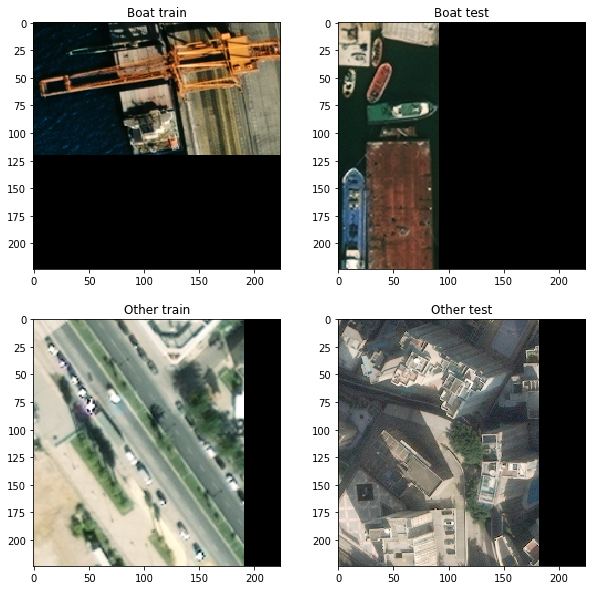

In [22]:
plt.figure(figsize=(10, 10))

for i, class_name in enumerate(chip_classes):
    train_chip = choice(glob.glob(join(train_directory, class_name, '*')) )
    plt.subplot(len(chip_classes), 2, 2*i+1)
    plt.title('{} {}'.format(class_name, 'train'))
    plot(plt, train_chip)
    test_chip = choice(glob.glob(join(test_directory, class_name, '*')) )
    plt.subplot(len(chip_classes), 2, 2*i+2)
    plt.title('{} {}'.format(class_name, 'test'))
    plot(plt, test_chip)

We're almost ready to train. 

We'll first implement a generic generator function that yields a batch of numpy arrays X and the corresponding one-hot vectors Y.

In [52]:
def preprocess(img):
    '''
    Subtract a given value from each band. 
    This is required due to the fact that VGG-16 is pretrained on ImageNet.  
    img is a 3d array where dimensions 1-3 correspond to the B, G, R bands.
    '''
    
    img[:,:,0] -= 103.939
    img[:,:,1] -= 116.779
    img[:,:,2] -= 123.68
    
    return img

def get_batch(data_dir, batch_size=5000, return_ids=False):
    '''
    data_dir: Includes one subdirectory per class, named after that class.
    batch_size: The size of the batch.
    return_ids: If true, return the chip names.
    '''
    
    # Get class names
    class_names = [sub_dir for sub_dir in os.listdir(data_dir)]
 
    # Get a list of all chips and shuffle it to introduce randomness
    chips = glob.glob(join(data_dir, '*', '*'))
    np.random.shuffle(chips)

    for i in range(0, len(chips), batch_size):
        
        chip_batch = chips[i:i+batch_size]
        
        X = np.array([preprocess(cv2.imread(chip).astype('float32')) for chip in chip_batch])
        y, ids = zip(*[[class_names.index(chip.split('/')[-2]), chip.split('/')[-1][:-4]] for chip in chip_batch])
        Y = to_categorical(y, num_classes=len(class_names))
        
        if return_ids:
            yield X, Y, ids
        else:
            yield X, Y

Load an existing model or a base model with ImageNet weights.

In [53]:
model_file = ''

if os.path.exists(model_file):
    backend.clear_session()
    model = load_model(model_file)
else:
    print 'Creating new model'
    model = VGG16(include_top=False, weights='imagenet', input_shape=(side, side, 3))
    x = Flatten()(model.layers[-1].output)        # remember that the final fully connected layers have not been included
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    preds = Dense(len(chip_classes), activation='softmax')(x)
    model = Model(inputs=model.input, outputs=preds)

sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Creating new model


First train the last dense layer and the softmax layer. 
If the size of the training set is larger than 5000, train in batches.

In [54]:
batch_size = 5000
no_batches = train_size/batch_size + 1

# Freeze all layers up to 19
for layer in model.layers[:19]:
    layer.trainable = False
            
for epoch in range(no_init_epochs):

    print 'Initialization epoch {}'.format(epoch + 1)

    batch = get_batch(data_dir=train_directory, batch_size=batch_size)
    
    for i in range(no_batches):

        print 'Batch {} of {}'.format(i+1, no_batches)        
        X, Y = next(batch)
        val_size = validate_percent*len(X)/100
        val_X, val_Y = X[:val_size], Y[:val_size]
        train_X, train_Y = X[val_size:], Y[val_size:]
        model.fit(train_X, train_Y, batch_size=32, validation_data=(val_X, val_Y), epochs=1)

Initialization epoch 1
Batch 1 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
4250/4250 [==============================] - 237s - loss: 0.5869 - acc: 0.8614 - val_loss: 0.2582 - val_acc: 0.9080
Batch 2 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
4250/4250 [==============================] - 237s - loss: 0.2356 - acc: 0.9132 - val_loss: 0.2213 - val_acc: 0.9093
Batch 3 of 3
Train on 3892 samples, validate on 686 samples
Epoch 1/1
3892/3892 [==============================] - 218s - loss: 0.2129 - acc: 0.9209 - val_loss: 0.1753 - val_acc: 0.9300


Now train the last three convolutional layers along with the last dense layer and the softmax layer.

In [55]:
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True
    
old_validation_loss = 1  
model_file = join(model_directory, 'model-epochs-{}-lr-{}.h5'.format(no_epochs, learning_rate))
    
for epoch in range(no_epochs):

    print 'Epoch {}'.format(epoch + 1)
    
    batch = get_batch(data_dir=train_directory, batch_size=batch_size)
    
    for i in range(no_batches):

        print 'Batch {} of {}'.format(i+1, no_batches)        
        X, Y = next(batch)
        val_size = validate_percent*len(X)/100
        val_X, val_Y = X[:val_size], Y[:val_size]
        train_X, train_Y = X[val_size:], Y[val_size:]
        model.fit(train_X, train_Y, batch_size=32, validation_data=(val_X, val_Y), epochs=1)
        new_validation_loss, new_validation_accuracy = model.evaluate(val_X, val_Y)
        if epoch == 0 or new_validation_loss < old_validation_loss:
            model.save(model_file)
            old_validation_loss = new_validation_loss

Epoch 1
Batch 1 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 2 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 3 of 3
Train on 3892 samples, validate on 686 samples
Epoch 1/1
686/686 [==============================] - 11s    
Epoch 2
Batch 1 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 2 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 3 of 3
Train on 3892 samples, validate on 686 samples
Epoch 1/1
686/686 [==============================] - 11s    
Epoch 3
Batch 1 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 2 of 3
Train on 4250 samples, validate on 750 samples
Epoch 1/1
750/750 [==============================] - 12s    
Batch 3 

Evaluate accuracy on the test set.

In [ ]:
model = load_model(model_file)
test_batch = get_batch(data_dir=test_directory, batch_size=2000)
test_X, test_Y = next(test_batch)

# from categorical to class indices
true_labels = [chip_classes[np.argmax(row)] for row in test_Y]

# predict function returns a probability distribution on every chip in the test set
probability_distributions = model.predict(test_X)
predictions = [chip_classes[np.argmax(distribution)] for distribution in probability_distributions]

In [91]:
cm = confusion_matrix(predictions, true_labels)
precision = float(cm[0, 0])/(cm[0, 0] + cm[0, 1])
recall = float(cm[0, 0])/(cm[0, 0] + cm[1, 0])
accuracy = float(cm[0, 0] + cm[1, 1])/(np.sum(cm))
print 'Confusion matrix: {}'.format(cm)
print 'Precision: {}'.format(precision)
print 'Recall: {}'.format(recall)
print 'F-score: {}'.format(2/(1/precision + 1/recall))
print 'Accuracy: {}'.format(accuracy)

Confusion matrix: [[ 224   14]
 [  46 1337]]
Precision: 0.941176470588
Recall: 0.82962962963
F-score: 0.88188976378
Accuracy: 0.962985811228
